In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import signal, stats
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2025-03-01 15:16:01.739101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740822361.784981   69195 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740822361.798052   69195 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 15:16:01.862211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData_one_sixth(cfileName):
    # Get file size in bytes.
    file_size = os.path.getsize(cfileName)
    # Each float32 is 4 bytes.
    num_floats = file_size // 4
    # Each complex sample consists of 2 floats.
    total_complex_samples = num_floats // 2
    # One-sixth of the complex samples.
    one_sixth_complex_samples = total_complex_samples // 6
    # Since each complex sample is 2 floats, calculate the count.
    count = one_sixth_complex_samples * 2
    # Read only the required number of float32 values.
    data = np.fromfile(cfileName, dtype="float32", count=count)
    # Convert to complex samples.
    complex_data = data[0::2] + 1j * data[1::2]
    return complex_data

In [3]:

def getData_half(cfileName):
    """
    Reads only the first half of the complex samples from a .cfile.
    The file is assumed to contain interleaved float32 I and Q samples.
    """
    # Get file size in bytes
    file_size = os.path.getsize(cfileName)
    # Determine total number of float32 samples in the file
    num_floats = file_size // 4
    # Each complex sample requires 2 floats.
    # The full complex array would have num_floats//2 elements.
    # To get only half of that, we need to read:
    count = (num_floats // 4) * 2  # (num_floats//4 complex samples)
    
    # Read only 'count' float32 numbers from the file
    data = np.fromfile(cfileName, dtype="float32", count=count)
    
    # Form complex samples: every pair (I, Q)
    data_complex = data[0::2] + 1j * data[1::2]
    
    return data_complex



In [4]:
num_samp_per_class = 10000
fs = 20e6        # sampling frequency
fft_size = feature_vector_size= 2048  # FFT window size
fft_overlap = 256  # overlap between segments

In [5]:
labels = ["original", "low data leakage", "moderate data leakage", "high data leakage"]

In [6]:
class_label = 0

In [69]:
original= getData_half("/media/rasi/Other/data/API-Security/hypothesis1/autheticated_firemware/original")
print(original.shape)

(212153772,)


# testing correlation heat maps

/tmp/ipykernel_69195/1224012680.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_original, t_original, Zxx_original = signal.stft(original, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


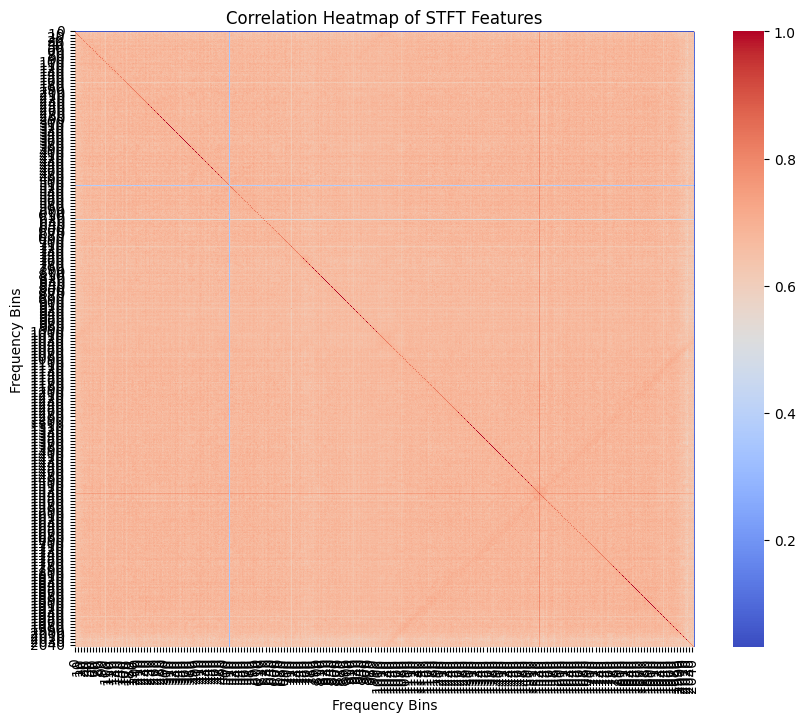

In [71]:
# f_original, t_original, Zxx_original = signal.stft(original, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
# Zxx_original = Zxx_original[:num_samp_per_class]
# mag = np.abs(Zxx_original)  # Shape: (frequency_bins, time_bins)

# # Flatten STFT for correlation calculation (each column represents a time segment)
# mag_flattened = mag.T  # Shape: (time_bins, frequency_bins)

# # Compute correlation matrix
# corr_matrix = np.corrcoef(mag_flattened, rowvar=False)

# # Plot correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, xticklabels=10, yticklabels=10)
# plt.title("Correlation Heatmap of STFT Features")
# plt.xlabel("Frequency Bins")
# plt.ylabel("Frequency Bins")
# plt.show()

In [68]:

Zxx_original = Zxx_original.transpose()

X = Zxx_original[:num_samp_per_class]
y = np.full(num_samp_per_class, class_label)


print(X.shape)
print(y.shape)
del original, Zxx_original, f_original, t_original

NameError: name 'original' is not defined

In [9]:
class_label = 1 # lower data leakage

In [ ]:
low= getData_one_sixth("/media/rasi/Other/data/API-Security/hypothesis2/traning/low")
print(low.shape)

(195560075,)


In [ ]:
f_low, t_low, Zxx_low = signal.stft(low, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
Zxx_low = Zxx_low.transpose()

X = np.concatenate((X, Zxx_low[:num_samp_per_class]), axis=0) 
y = np.concatenate((y, np.full(num_samp_per_class, class_label)), axis=0)

print(X.shape)
print(y.shape)
del low, Zxx_low, f_low, t_low

/tmp/ipykernel_69195/3707494615.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_low, t_low, Zxx_low = signal.stft(low, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


(20000, 2048)
(20000,)


In [12]:
class_label = 2

In [13]:
moderate= getData_one_sixth("/media/rasi/Other/data/API-Security/hypothesis2/traning/moderate")
print(moderate.shape)

(195581304,)


In [14]:
f_moderate, t_moderate, Zxx_moderate = signal.stft(moderate, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
Zxx_moderate = Zxx_moderate.transpose()

X = np.concatenate((X, Zxx_moderate[:num_samp_per_class]), axis=0) 
y = np.concatenate((y, np.full(num_samp_per_class, class_label)), axis=0)

print(X.shape)
print(y.shape)
del moderate, Zxx_moderate, f_moderate, t_moderate

/tmp/ipykernel_69195/3663119809.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_moderate, t_moderate, Zxx_moderate = signal.stft(moderate, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


(30000, 2048)
(30000,)


In [15]:
class_label = 3

In [16]:
high= getData_one_sixth("/media/rasi/Other/data/API-Security/hypothesis2/traning/high")
print(high.shape)

(194729849,)


In [17]:
f_high, t_high, Zxx_high = signal.stft(high, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
Zxx_high = Zxx_high.transpose()

X = np.concatenate((X, Zxx_high[:num_samp_per_class]), axis=0) 
y = np.concatenate((y, np.full(num_samp_per_class, class_label)), axis=0)


print(X.shape)
print(y.shape)
del high, Zxx_high, f_high, t_high

/tmp/ipykernel_69195/1495850637.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_high, t_high, Zxx_high = signal.stft(high, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


(40000, 2048)
(40000,)


Building the Model

In [18]:
X = abs(X)

# scaling the features (only real part of the data can be used)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [19]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# SVM Train

In [20]:
# clf = SVC()
# clf.fit(X_train, y_train)

# # Make predictions
# y_pred = clf.predict(X_test)

# # Evaluate accuracy
# print("SVM Accuracy:", accuracy_score(y_test, y_pred))

# Result

In [21]:

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

In [22]:
# from sklearn.metrics import confusion_matrix

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# print("Confusion Matrix:")
# print(cm)

In [23]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['original','Low', 'Moderate', 'High'], yticklabels=['original', 'Low', 'Moderate', 'High'])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

# neural model

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(feature_vector_size,)))

model.add(keras.layers.Dense(1400, activation="relu"))
model.add(keras.layers.Dense(800, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(250, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 1400)           │     2,868,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 800)            │     1,120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 500)            │       400,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,541,260 (17.32 MB)

 Trainable params: 4,541,260 (17.32 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [45]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./leakage.keras", save_best_only=True)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[checkpoint_cb])

Epoch 1/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3089 - loss: 1.5817 - val_accuracy: 0.3544 - val_loss: 1.3153
Epoch 2/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4662 - loss: 1.2748 - val_accuracy: 0.5289 - val_loss: 1.1797
Epoch 3/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5261 - loss: 1.1409 - val_accuracy: 0.5675 - val_loss: 1.0626
Epoch 4/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5561 - loss: 1.0348 - val_accuracy: 0.5719 - val_loss: 1.0116
Epoch 5/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5939 - loss: 0.9716 - val_accuracy: 0.6189 - val_loss: 0.9621
Epoch 6/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6212 - loss: 0.9157 - val_accuracy: 0.5606 - val_loss: 1.0009
Epoch 7/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6531 - loss: 0.8625 - val_accuracy: 0.6589 - val_loss: 0.8876
Epoch 8/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6836 - loss: 0.8178 - 

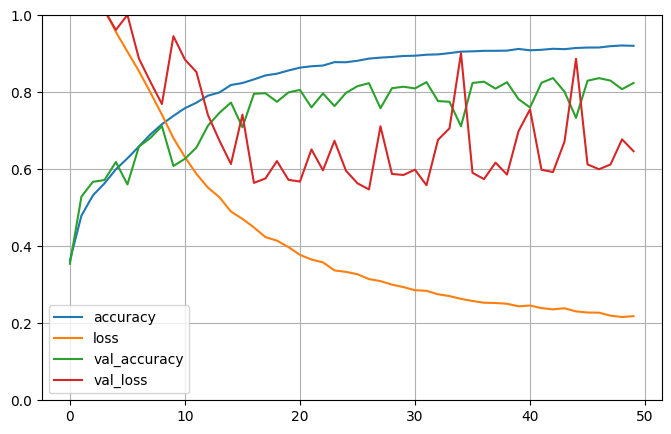

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [47]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8109 - loss: 0.7268
test loss, test acc: [0.6822019219398499, 0.8209999799728394]


In [49]:
model = keras.models.load_model("./leakage.keras")

In [50]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8269 - loss: 0.5907
test loss, test acc: [0.5573269724845886, 0.827750027179718]


In [62]:


y_pred = np.argmax(model.predict(X_test), axis=1) 

if y_test.ndim > 1:  # If y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

print(y_pred)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[2 1 0 ... 1 0 0]


In [67]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[832  57  30  90]
 [ 49 826  71  42]
 [ 33  80 871  51]
 [ 78  52  56 782]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1009
           1       0.81      0.84      0.82       988
           2       0.85      0.84      0.84      1035
           3       0.81      0.81      0.81       968

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



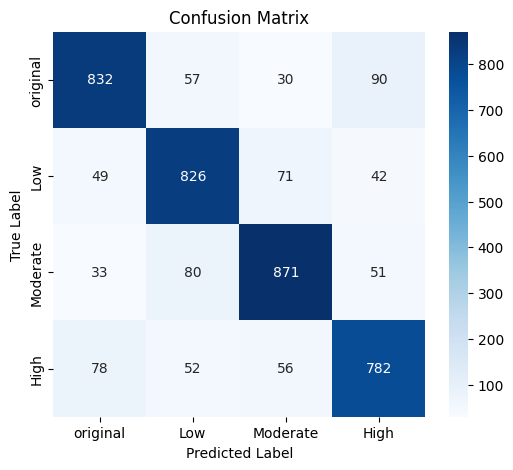

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['original','Low', 'Moderate', 'High'], yticklabels=['original', 'Low', 'Moderate', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()